In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# 2) Event Generation with Diffusion Models

(c)

The following code provides a minimal implementation of a Denoising Diffusion Probabilistic Model (DDPM). It uses the same notation as in the lecture notes and https://arxiv.org/pdf/2305.10475.pdf. We recommend reading it alongside Figures 1, 2 of the paper.

In [260]:
class DDPM(nn.Module):
    
    def __init__(self, 
                data_dim, T=100, 
                 n_layers=3, hidden_dim=64):
        super().__init__()
        # initialize diffusion parameters
        self.T = T
        self.data_dim = data_dim
        self.beta = torch.linspace(1e-4, 2e-2, self.T)
        self.beta_bar = 1-torch.cumprod(1-self.beta, dim=0)
        self.sigma2 = torch.ones_like(self.beta)
        self.sigma2[1:] = self.beta_bar[:-1]/self.beta_bar[1:] * self.beta[1:]
        
        # construct simple MLP
        layers = []
        # network gets xt (data_dim-dimensional) and T (1-dimensional) as inputs
        layers.append(nn.Linear(self.data_dim+1, hidden_dim))
        for _ in range(n_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, self.data_dim))
        self.net = nn.Sequential(*layers)
        
    def batch_loss(self, x0):
        t = torch.randint(low=1, high=self.T, size=(x0.shape[0], 1))
        epsilon = torch.randn_like(x0)
        
        # TODO: Compute x_t(x_0, epsilon)
        xt = torch.sqrt(1-self.beta_bar[t])*x0 + torch.sqrt(self.beta_bar[t])*epsilon
        
        epsilon_theta = self.net(torch.cat((xt, t), dim=1))
        
        # loss function (eqn 17 in the paper)
        prefactor = 1/(2*self.sigma2[t]) * self.beta[t]**2 / (1-self.beta[t]) / self.beta_bar[t]
        loss = prefactor.unsqueeze(-1) * (epsilon - epsilon_theta)**2 
        return loss.mean()
    
    def sample(self, n_samples):
        # x_t starts at x_T and is diffused over x_{T-1}, x_{T-2} etc to x_0
        xt = torch.randn(n_samples, self.data_dim)
        for t in reversed(range(self.T)):
            z = torch.randn(n_samples, self.data_dim) if t>0 else 0.
            epsilon_theta = self.net(torch.cat((xt, torch.full((xt.shape[0], 1),
                                                             t)), dim=1))
            
            # TODO: Compute x_t (x_{t+1}, epsilon_theta, z)
            xt = (xt - epsilon_theta * self.beta[t] / torch.sqrt(self.beta_bar[t])) / torch.sqrt(1-self.beta[t]) + torch.sqrt(self.sigma2[t]) * z
        return xt

In [261]:
# standard imports
from sklearn.datasets import make_moons

BATCHSIZE = 100
N_DIM = 2
    
model = DDPM(data_dim=N_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# a very basic training loop
losses = []
for i in range(10000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
    x0 = torch.Tensor(data)
    # compute loss of DDPM
    loss = model.batch_loss(x0)
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# sample from the DDPM
with torch.no_grad():
    samples = model.sample(BATCHSIZE)

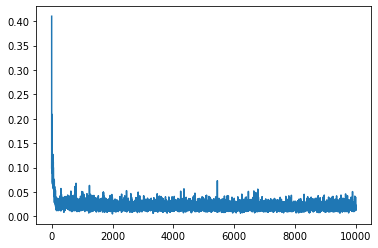

In [262]:
plt.plot(losses)
plt.show()

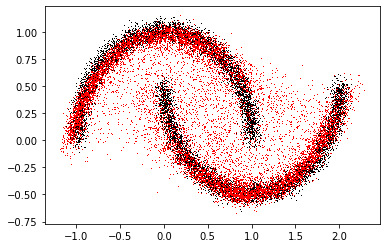

In [263]:
with torch.no_grad():
    samples = model.sample(10000)
truth, _ = make_moons(n_samples=10000, noise=0.05)
plt.plot(truth[:,0], truth[:,1], "k,")
plt.plot(samples[:,0], samples[:,1], "r,")
plt.show()

(d)

In [ ]:
# download data to folder data09
# this might take some time (50MB)
# you can also do this manually (download + unpack zip)
import os, sys
import wget
from zipfile import ZipFile
from tqdm import tqdm

DESTINATION = "data09"
url = "https://www.thphys.uni-heidelberg.de/~plehn/pics/"
filename = "tutorial-11-data.zip"
url = url + filename

os.makedirs(DESTINATION, exist_ok=True)
os.chdir(DESTINATION)
wget.download(url, filename)
with ZipFile(filename, "r") as zip_ref:
    for file in tqdm(iterable=zip_ref.namelist(), total=len(zip_ref.namelist())):
        zip_ref.extract(member=file)
os.chdir("..")
%ls data09

In [264]:
data_trn = np.load("data09/tutorial-11-data/dy_trn_data.npy")
data_tst = np.load("data09/tutorial-11-data/dy_tst_data.npy")
data_val = np.load("data09/tutorial-11-data/dy_val_data.npy")
print(data_trn.shape, data_tst.shape, data_val.shape)

(1384081, 8) (296588, 8) (296588, 8)


In [265]:
def get_mass(particle):
    return np.sqrt(np.clip(particle[:,0]**2 - np.sum(particle[:,1:]**2, axis=-1), 0, None))

def get_pt(particle):
    return np.sqrt(particle[:,1]**2 + particle[:,2]**2)

def get_eta(particle):
    p_absolute = np.sqrt(np.sum(particle[:,1:]**2, axis=-1))
    return np.arctanh(particle[:,3] / p_absolute)

def get_phi(particle):
    return np.arctan2(particle[:,2], particle[:,1])

def get_pt_phi_eta_mass(particle):
    pt = get_pt(particle)
    phi = get_phi(particle)
    eta = get_eta(particle)
    mass = get_mass(particle)
    return np.stack((pt, phi, eta, mass), axis=-1)

In [266]:
# cuts in the dataset
get_pt(data_tst[:,:4]).min(), get_pt(data_tst[:,4:]).min() # pt cuts
get_eta(data_tst[:,:4]).min(), get_eta(data_tst[:,:4]).max()

eta_cut = 2.5 + 1e-5 # should be 2.5 but one event is weird
pt_cut = 10.

In [267]:
def preprocess(events, mean=None, std=None):
    particle1, particle2 = events[:,:4], events[:,4:]
    events_jetcoordinates = np.stack((get_pt(particle1), get_phi(particle1), get_eta(particle1), get_mass(particle1), get_pt(particle2), get_phi(particle2), get_eta(particle2), get_mass(particle2)), axis=-1)
    events_reduced = events_jetcoordinates[:,[0,2,6]]
    
    events_reduced[:,0] = np.log(events_reduced[:,0] - pt_cut)
    events_reduced[:,1:] = np.arctanh(events_reduced[:,1:] / eta_cut)
    
    if mean is None or std is None:
        mean = events_reduced.mean(axis=0)
        std = events_reduced.std(axis=0)
    events_reduced = (events_reduced - mean) / std
    
    assert np.isfinite(events_reduced).all()
    events_reduced = torch.tensor(events_reduced).float()
    return events_reduced, mean, std
    
def undo_preprocess(events_reduced, mean, std):
    events_reduced = events_reduced * std + mean
    
    events_reduced[:,0] = np.exp(events_reduced[:,0]) + pt_cut
    events_reduced[:,[1,2]] = np.tanh(events_reduced[:,[1,2]]) * eta_cut
    
    pt1, eta1, eta2 = events_reduced.T
    phi1 = np.random.uniform(0, 2*np.pi, events_reduced.shape[0])
    mass1, mass2 = np.ones((2, events_reduced.shape[0])) * 0.105
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    e1 = np.sqrt(mass1**2 + px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pt2 = pt1
    pz2 = pt2 * np.sinh(eta2)
    e2 = np.sqrt(mass2**2 + px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

In [268]:
from torch.utils.data import TensorDataset, DataLoader

data_trn_prepd, mean, std = preprocess(data_trn)
data_tst_prepd, _, _ = preprocess(data_tst, mean, std)
data_val_prepd, _, _ = preprocess(data_val, mean, std)

dataset_trn = TensorDataset((data_trn_prepd))
dataset_tst = TensorDataset((data_tst_prepd))
dataset_val = TensorDataset((data_val_prepd))

batchsize = 4096
dataloader_trn = DataLoader(dataset_trn, batch_size=batchsize, shuffle=True)
dataloader_tst = DataLoader(dataset_tst, batch_size=batchsize, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, shuffle=False)

In [269]:
def batch_loss(model, x):
    loss = model.batch_loss(x)
    return loss

def train_epoch(model, loader, losses):
    model.train()
    for (x,) in loader:
        loss = batch_loss(model, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def val_epoch(model, loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for (x,) in loader:
            loss = batch_loss(model, x)
            losses.append(loss.item())
    return np.mean(losses)

In [270]:
# construct DDPM
ndim = 3
model = DDPM(ndim)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters} parameters")
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train DDPM
nepochs = 5
losses = []
for epoch in range(nepochs):
    losses = train_epoch(model, dataloader_trn, losses)
    val_loss = val_epoch(model, dataloader_val)
    print(f"{epoch}/{nepochs}\t {val_loss}")

Model has 8835 parameters
0/5	 0.025137206182292062
1/5	 0.024092435300962566
2/5	 0.02388990713819249
3/5	 0.023796810296504465
4/5	 0.02352490194448053


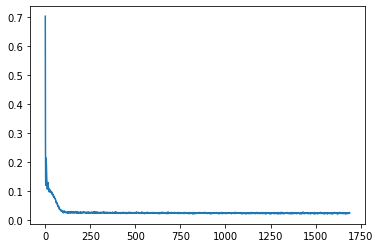

In [271]:
plt.plot(losses)
plt.show()

In [272]:
with torch.no_grad():
    samples_prepd = model.sample(50000)
samples = undo_preprocess(samples_prepd.detach().numpy(), mean, std)
print(samples_prepd.shape, samples.shape)

torch.Size([50000, 3]) (50000, 8)


In [35]:
components_Eppp = ["E [GeV]", "px [GeV]", "py [GeV]", "pz [GeV]"]
components_jetcoordinates = ["pt [GeV]", "phi", "eta", "mass [GeV]"]
def plot(truth, generated, bins=50):
    fig, axs = plt.subplots(4,4, figsize=(15,15))
    
    # plot (E, px, py, pz) for both particles
    for iparticle in range(2):
        for icomponent in range(4):
            ax = axs[iparticle, icomponent]
            xlabel = f"{components_Eppp[icomponent]} of particle {iparticle+1}"
            i = iparticle*4 + icomponent
            
            bins_local = bins
            _, bins_local, _ = ax.hist(truth[:,i], bins=bins_local, alpha=.5, label="truth", density=True)
            ax.hist(generated[:,i], bins=bins_local, alpha=.5, label="model", density=True)
            ax.legend()
            ax.set_xlabel(xlabel)
    
    # plot (pt phi eta mass) for both particles
    truth = np.concatenate((get_pt_phi_eta_mass(truth[:,:4]), 
                            get_pt_phi_eta_mass(truth[:,4:])), axis=-1)
    generated = np.concatenate((get_pt_phi_eta_mass(generated[:,:4]), 
                                get_pt_phi_eta_mass(generated[:,4:])), axis=-1)
    for iparticle in range(2):
        for icomponent in range(4):
            ax = axs[2+iparticle, icomponent]
            xlabel = f"{components_jetcoordinates[icomponent]} of particle {iparticle+1}"
            i = iparticle*4 + icomponent
            
            bins_local = bins
            _, bins_local, _ = ax.hist(truth[:,i], bins=bins_local, alpha=.5, label="truth", density=True)
            ax.hist(generated[:,i], bins=bins_local, alpha=.5, label="model", density=True)
            ax.legend()
            ax.set_xlabel(xlabel)

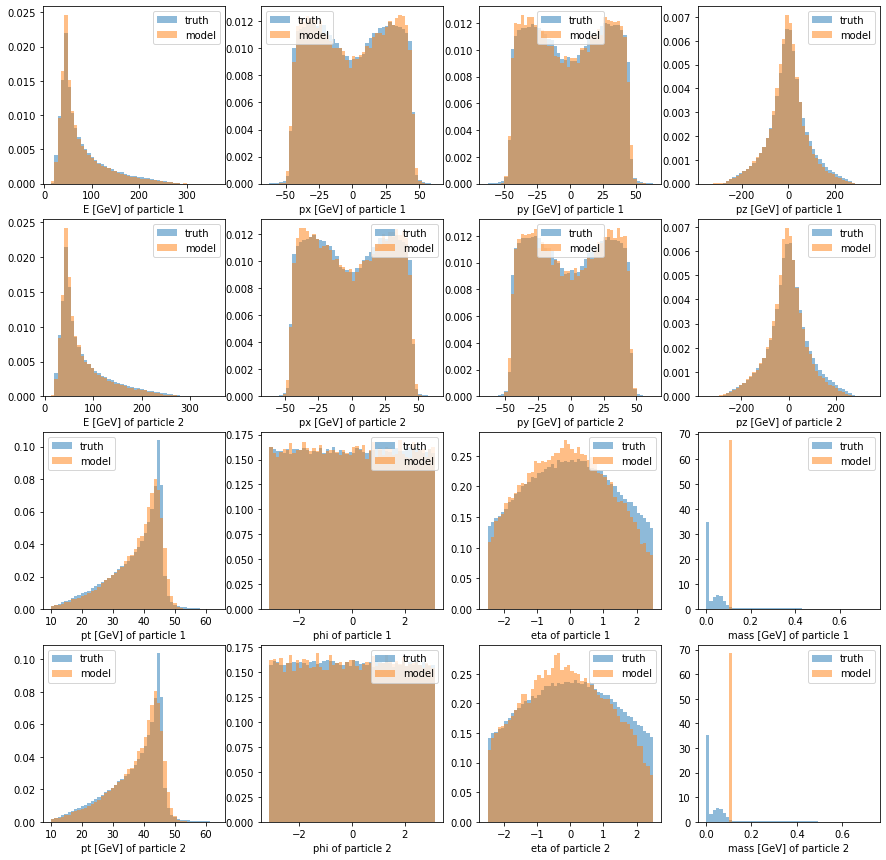

In [273]:
plot(data_tst, samples)

(e)

This is a minimal implementation of Conditional Flow Matching (CFM). Again, it uses the same notation as in the lecture notes and https://arxiv.org/pdf/2305.10475.pdf. We recommend reading it alongside Figures 3 of the paper.

In [274]:
from scipy.integrate import solve_ivp

class CFM(nn.Module):
    
    def __init__(self, data_dim, n_layers=3, hidden_dim=64):
        super().__init__()
        self.data_dim = data_dim
        
        # construct simple MLP
        layers = []
        # network gets xt (data_dim-dimensional) and t (1-dimensional) as inputs
        layers.append(nn.Linear(self.data_dim+1, hidden_dim))
        for _ in range(n_layers-1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, self.data_dim))
        self.net = nn.Sequential(*layers)
        
    def batch_loss(self, x0):
        t = torch.rand(x0.shape[0], 1)
        epsilon = torch.randn_like(x0)
        
        # TODO: Define linear trajectory
        x_t = (1-t)*x0 + t*epsilon
        v_t = -x0 + epsilon
        
        # Predict v_theta with neural network
        v_theta = self.net(torch.cat((x_t, t), dim=1))
        
        # MSE loss
        loss = torch.mean( (v_theta - v_t)**2)
        return loss
    
    def sample(self, n_samples):
        # function to be called by the ODE solver
        # scipy expects 1d arrays -> have to flatten and unflatten
        def v(t, x_t):
            x_t = torch.tensor(x_t).reshape(n_samples, self.data_dim).float()
            t = t * torch.ones(x_t.shape[0], 1).float()
            
            v_t = self.net(torch.cat((x_t, t), dim=1)).flatten().numpy()
            return v_t

        # apply ODE solver starting from N(0,1) noise
        epsilon = np.random.randn(n_samples, self.data_dim)
        sol = solve_ivp(v, (1, 0), epsilon.flatten())
        events = sol.y[:,-1].reshape(n_samples, self.data_dim)
        return events         

In [275]:
# standard imports
from sklearn.datasets import make_moons

BATCHSIZE = 1000
N_DIM = 2
    
model = CFM(data_dim=N_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# a very basic training loop
losses = []
for i in range(1000):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
    x0 = torch.Tensor(data)
    # compute loss of DDPM
    loss = model.batch_loss(x0)
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

# sample from the CFM
with torch.no_grad():
    samples = model.sample(BATCHSIZE)

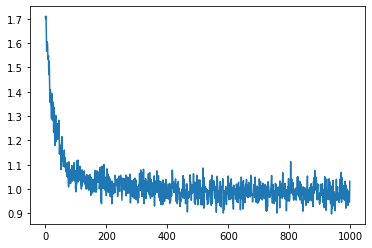

In [276]:
plt.plot(losses)
plt.show()

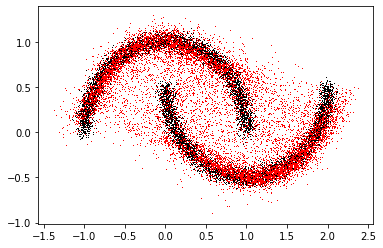

In [277]:
with torch.no_grad():
    samples = model.sample(10000)
truth, _ = make_moons(n_samples=10000, noise=0.05)
plt.plot(truth[:,0], truth[:,1], "k,")
plt.plot(samples[:,0], samples[:,1], "r,")
plt.show()

(f) 

In [256]:
# construct CFM
ndim = 3
model = CFM(ndim)
total_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Model has {total_parameters} parameters")
    
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train CFM
nepochs = 5
losses = []
for epoch in range(nepochs):
    losses = train_epoch(model, dataloader_trn, losses)
    val_loss = val_epoch(model, dataloader_val)
    print(f"{epoch}/{nepochs}\t {val_loss}")

Model has 8835 parameters
0/5	 1.3899259256989989
1/5	 1.3707882459849527
2/5	 1.3607870209706974
3/5	 1.3546251336189166
4/5	 1.3552507537685028


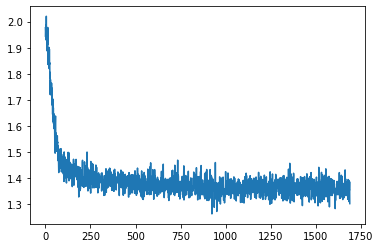

In [257]:
plt.plot(losses)
plt.show()

In [258]:
with torch.no_grad():
    samples_prepd = model.sample(50000)
samples = undo_preprocess(samples_prepd, mean, std)
print(samples_prepd.shape, samples.shape)

(50000, 3) (50000, 8)


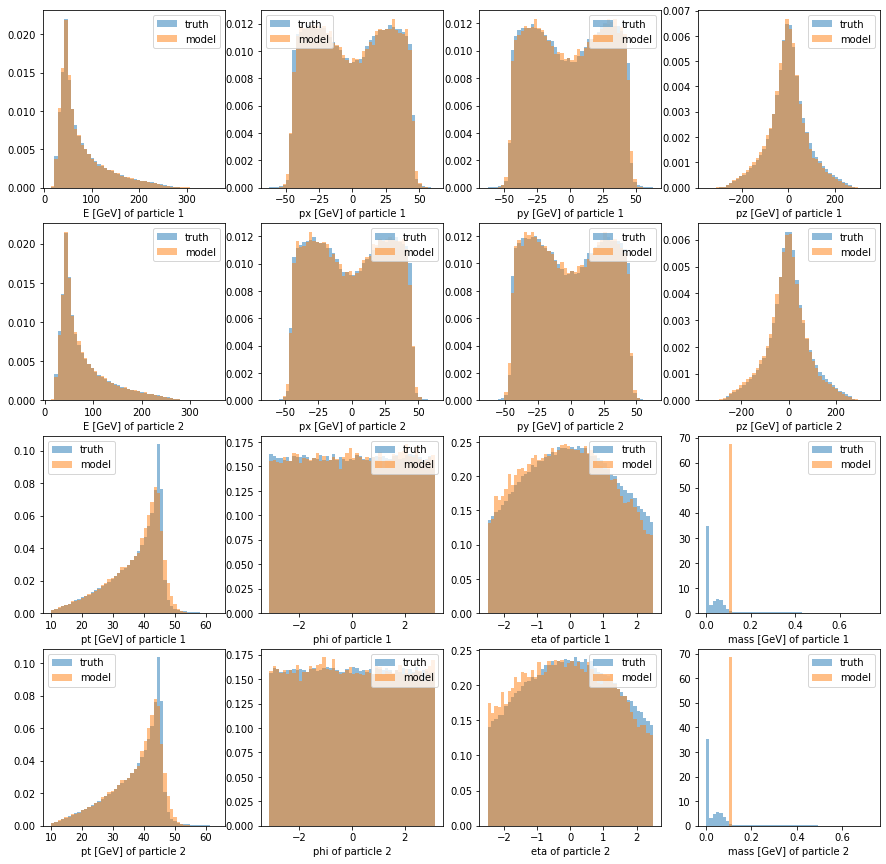

In [259]:
plot(data_tst, samples)

# 3) Unfolding with Normalizing Flows

For this exercise you we have to extend the INN of sheet 10, exercise 2 to allow for extra, conditional inputs. The following code demonstrates how to implement a 1-dimensional random condition for INNs within the FrEIA framework. 

In [38]:
# standard imports
import torch
import torch.nn as nn
from sklearn.datasets import make_moons

# FrEIA imports
import FrEIA.framework as Ff
import FrEIA.modules as Fm

BATCHSIZE = 100
N_DIM = 2

# we define a subnet for use inside an affine coupling block
# for more detailed information see the full tutorial
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, 512), nn.ReLU(),
                         nn.Linear(512,  dims_out))

# a simple chain of operations is collected by ReversibleSequential
inn = Ff.SequenceINN(N_DIM)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True,
              cond=0, cond_shape=(1,))

optimizer = torch.optim.Adam(inn.parameters(), lr=0.001)

# a very basic training loop
for i in range(500):
    optimizer.zero_grad()
    # sample data from the moons distribution
    data, label = make_moons(n_samples=BATCHSIZE, noise=0.05)
    x = torch.Tensor(data)
    c = torch.randn(BATCHSIZE, 1)
    # pass to INN and get transformed variable z and log Jacobian determinant
    z, log_jac_det = inn(x, c=(c,))
    # calculate the negative log-likelihood of the model with a standard normal prior
    loss = 0.5*torch.sum(z**2, 1) - log_jac_det
    loss = loss.mean() / N_DIM
    # backpropagate and update the weights
    loss.backward()
    optimizer.step()

# sample from the INN by sampling from a standard normal and transforming
# it in the reverse direction
z = torch.randn(BATCHSIZE, N_DIM)
c = torch.randn(BATCHSIZE, 1)
samples, _ = inn(z, c=(c,), rev=True)

Load the dataset (same as exercise 1)

In [2]:
data_trn = np.load("data09/tutorial-11-data/dy_trn_data.npy")
data_tst = np.load("data09/tutorial-11-data/dy_tst_data.npy")
data_val = np.load("data09/tutorial-11-data/dy_val_data.npy")
print(data_trn.shape, data_tst.shape, data_val.shape)

(1384081, 8) (296588, 8) (296588, 8)


In [3]:
def get_mass(particle):
    return np.sqrt(np.clip(particle[:,0]**2 - np.sum(particle[:,1:]**2, axis=-1), 0, None))

def get_pt(particle):
    return np.sqrt(particle[:,1]**2 + particle[:,2]**2)

def get_eta(particle):
    p_absolute = np.sqrt(np.sum(particle[:,1:]**2, axis=-1))
    return np.arctanh(particle[:,3] / p_absolute)

def get_phi(particle):
    return np.arctan2(particle[:,2], particle[:,1])

def get_pt_phi_eta_mass(particle):
    pt = get_pt(particle)
    phi = get_phi(particle)
    eta = get_eta(particle)
    mass = get_mass(particle)
    return np.stack((pt, phi, eta, mass), axis=-1)

In [11]:
# cuts in the dataset
get_pt(data_tst[:,:4]).min(), get_pt(data_tst[:,4:]).min() # pt cuts
get_eta(data_tst[:,:4]).min(), get_eta(data_tst[:,:4]).max()

eta_cut = 2.5 + 1e-5 # should be 2.5 but one event is weird
pt_cut = 10.

In [12]:
def preprocess(events, mean=None, std=None):
    particle1, particle2 = events[:,:4], events[:,4:]
    events_jetcoordinates = np.stack((get_pt(particle1), get_phi(particle1), get_eta(particle1), get_mass(particle1), get_pt(particle2), get_phi(particle2), get_eta(particle2), get_mass(particle2)), axis=-1)
    events_reduced = events_jetcoordinates[:,[0,2,6]]
    
    events_reduced[:,0] = np.log(events_reduced[:,0] - pt_cut)
    events_reduced[:,1:] = np.arctanh(events_reduced[:,1:] / eta_cut)
    
    if mean is None or std is None:
        mean = events_reduced.mean(axis=0)
        std = events_reduced.std(axis=0)
    events_reduced = (events_reduced - mean) / std
    
    assert np.isfinite(events_reduced).all()
    events_reduced = torch.tensor(events_reduced).float()
    return events_reduced, mean, std
    
def undo_preprocess(events_reduced, mean, std):
    events_reduced = events_reduced * std + mean
    
    events_reduced[:,0] = np.exp(events_reduced[:,0]) + pt_cut
    events_reduced[:,[1,2]] = np.tanh(events_reduced[:,[1,2]]) * eta_cut
    
    pt1, eta1, eta2 = events_reduced.T
    phi1 = np.random.uniform(0, 2*np.pi, events_reduced.shape[0])
    mass1, mass2 = np.ones((2, events_reduced.shape[0])) * 0.105
    px1 = pt1 * np.cos(phi1)
    py1 = pt1 * np.sin(phi1)
    pz1 = pt1 * np.sinh(eta1)
    e1 = np.sqrt(mass1**2 + px1**2 + py1**2 + pz1**2)
    px2 = -px1
    py2 = -py1
    pt2 = pt1
    pz2 = pt2 * np.sinh(eta2)
    e2 = np.sqrt(mass2**2 + px2**2 + py2**2 + pz2**2)
    return np.stack((e1, px1, py1, pz1, e2, px2, py2, pz2), axis=-1)

(a)

In [7]:
def toy_detector_sim(data):
    split_frac = np.random.uniform(0,1,(len(data),1))
    q1 = split_frac * data[:,:4]
    q2 = (1.-split_frac) * data[:,:4]
    q3 = data[:,4:]
    q_all = np.concatenate((q1, q2, q3), axis=1)
    q_noise = q_all * np.random.normal(0.9, 0.05, q_all.shape)
    return q_noise

In [8]:
det_trn_data = toy_detector_sim(data_trn)
det_tst_data = toy_detector_sim(data_tst)
det_val_data = toy_detector_sim(data_val)

In [9]:
# Normalize detector-level data
det_trn_mean = np.mean(det_trn_data, axis=0)
det_trn_std = np.std(det_trn_data, axis=0)
det_trn_data_p = torch.Tensor((det_trn_data - det_trn_mean) / det_trn_std)
det_val_data_p = torch.Tensor((det_val_data - det_trn_mean) / det_trn_std)
det_tst_data_p = torch.Tensor((det_tst_data - det_trn_mean) / det_trn_std)

In [19]:
from torch.utils.data import TensorDataset, DataLoader

data_trn_prepd, mean, std = preprocess(data_trn)
data_tst_prepd, _, _ = preprocess(data_tst, mean, std)
data_val_prepd, _, _ = preprocess(data_val, mean, std)

dataset_trn = TensorDataset(data_trn_prepd, det_trn_data_p)
dataset_tst = TensorDataset(data_tst_prepd, det_tst_data_p)
dataset_val = TensorDataset(data_val_prepd, det_val_data_p)

batchsize = 1024
dataloader_trn = DataLoader(dataset_trn, batch_size=batchsize, shuffle=True)
dataloader_tst = DataLoader(dataset_tst, batch_size=batchsize, shuffle=False)
dataloader_val = DataLoader(dataset_val, batch_size=batchsize, shuffle=False)

(b)

In [20]:
def inn_loss(z, log_jac_det):
    l = 0.5*torch.sum(z**2, dim=1) - log_jac_det
    return l.mean() / z.shape[1]

In [29]:
def batch_loss(model, data):
    x, c = data
    z, log_jac_det = model(x, c=(c,))
    loss = inn_loss(z, log_jac_det)
    return loss

def train_epoch(model, loader, losses):
    model.train()
    for data in loader:
        loss = batch_loss(model, data)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

def val_epoch(model, loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for data in loader:
            loss = batch_loss(model, data)
            losses.append(loss.item())
    return np.mean(losses)

In [54]:
# construct INN
import FrEIA.framework as Ff
import FrEIA.modules as Fm
ndim = 3
def subnet_fc(dims_in, dims_out):
    return nn.Sequential(
        nn.Linear(dims_in, 32), 
        nn.ReLU(),
        nn.Linear(32, 32), 
        nn.ReLU(),
        nn.Linear(32,  dims_out)
    )
inn = Ff.SequenceINN(ndim)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True,
              cond=0, cond_shape=(12,))
total_parameters = sum(p.numel() for p in inn.parameters() if p.requires_grad)
print(f"INN has {total_parameters} parameters")
    
optimizer = torch.optim.Adam(inn.parameters(), lr=1e-3)

# train INN
nepochs = 2
losses = []
for epoch in range(nepochs):
    losses = train_epoch(inn, dataloader_trn, losses)
    val_loss = val_epoch(inn, dataloader_val)
    print(f"{epoch}/{nepochs}\t {val_loss}")

INN has 12864 parameters
0/2	 -2.310439999350186
1/2	 -2.661410591520112


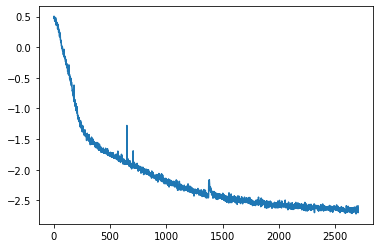

In [55]:
plt.plot(losses)
plt.show()

In [56]:
with torch.no_grad():
    z = torch.randn(det_tst_data_p.shape[0], ndim)
    c = det_tst_data_p
    samples_prepd, _ = inn(z, c=(c,), rev=True)
samples = undo_preprocess(samples_prepd.detach().numpy(), mean, std)
print(samples_prepd.shape, samples.shape)

torch.Size([296588, 3]) (296588, 8)


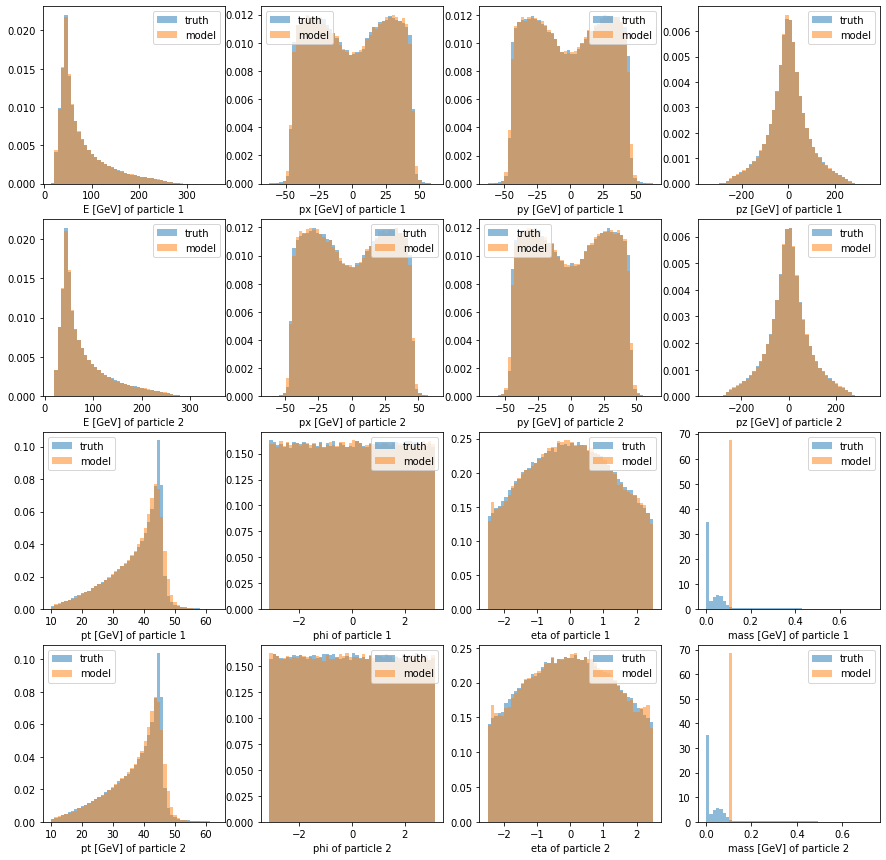

In [57]:
plot(data_tst, samples)

(c)

In [58]:
n_samples = 1000
n_events = 10

unfolded_events = []
for i in range(n_events):
    z = torch.randn((n_samples, ndim))
    c = det_tst_data_p[i].repeat(n_samples, 1)
    x, _ = inn(z, c=(c,), rev=True)
    x = undo_preprocess(x.detach().numpy(), mean, std)
    unfolded_events.append(x)

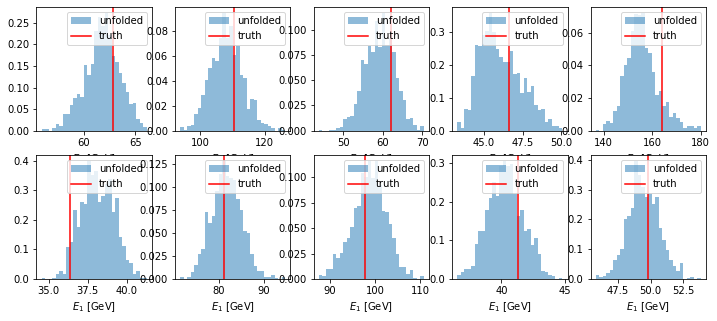

In [59]:
fig, axs = plt.subplots(2,5, figsize=(12,5))
for i in range(2):
    for j in range(5):
        k = i*5 + j
        axs[i,j].hist(unfolded_events[k][:,0], alpha=.5, density=True, 
                     bins=30, label="unfolded")
        axs[i,j].axvline(data_tst[k,0], label="truth", color="r")
        axs[i,j].set_xlabel("$E_1$ [GeV]")
        axs[i,j].legend()
plt.show()